<a href="https://colab.research.google.com/github/nanditanarendar/Pulsar_Glitches_Thesis/blob/main/NS_Vela_0_6M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# ---------------- Constants ----------------
b0 = 2.95384
b1 = 0.01126
b2 = 0.27421
b3 = 3.42704
b5 = 1
b4 = 0.33854

In [2]:
class CurvedEOS:
    """
    Curved-spacetime EOS with both numeric and analytic dP/dn.
    - numeric derivative (finite difference) is used by default
    - analytic derivative is used only as a fallback
    """

    def __init__(self, c=0.0):
        self.c = float(c)

    def pressure(self, n, phi):
        # Ensure scalar and non-negative n
        n = max(float(n), 0.0)
        phi = float(phi)

        bn = b2 * n
        # safe fractional powers (bn >= 0)
        bn_13 = bn**(1.0/3.0) if bn >= 0.0 else 0.0
        bn_23 = bn**(2.0/3.0) if bn >= 0.0 else 0.0
        root = np.sqrt(bn_23 + 1.0)

        term1 = root * (2.0 * bn - 3.0 * bn_13)
        term2 = 3.0 * np.log(bn_13 + root) if (bn_13 + root) > 0 else 0.0

        term3 = - self.c * (bn**2)    # extra term c * (bn)^2

        P0 = (b3 / 8.0) * (term1 + term2 + term3)
        return float(np.exp(phi) * P0)

    def energy_density(self, n, phi):
        n = max(float(n), 0.0)
        phi = float(phi)

        bn = b2 * n
        root = np.sqrt(bn**(2.0/3.0) + 1.0) if bn >= 0.0 else 1.0
        # rho = -P + exp(phi) * (b3 * root * bn)
        return float(-self.pressure(n, phi) + np.exp(phi) * (b3 * root * bn))

    def dP_dn_analytic(self, n, phi):
        """
        Analytic derivative of P wrt n (returns ∂P/∂n at fixed phi).
        """
        n = max(float(n), 0.0)
        phi = float(phi)

        bn = b2 * n
        bn_23 = (bn)**(2.0/3.0) if bn >= 0.0 else 0.0
        root = np.sqrt(bn_23 + 1.0)

        # base analytic derivative of P0(n)
        dP0dn_base = (b3 / 3.0) * (bn_23 / root) if root > 0 else 0.0

        # derivative of term3 = c * (bn)^2
        # d/dn [ (bn)^2 ] = 2 * (bn) * d(bn)/dn = 2 * bn * b2
        dP0dn_extra = - 2.0 * self.c * (bn) * b2

        dP0dn = dP0dn_base + dP0dn_extra
        return float(np.exp(phi) * dP0dn)

    def dP_dn_numeric(self, n, phi, eps_rel=1e-8):
        """
        Numeric central finite-difference derivative:
        (∂P/∂n)_phi = exp(phi) * dP0/dn, computed by central difference on P0.
        This mirrors your old derivative helper.
        """
        n = float(n)
        phi = float(phi)
        pre = np.exp(phi)

        # h chosen relative to n, but avoid extremely small h
        h = max(1e-12, eps_rel * max(1.0, abs(n)))
        n_minus = max(n - h, 0.0)
        n_plus = n + h

        # P0 = P(n,phi) / exp(phi)
        Pp0 = (self.pressure(n_plus, phi) / pre)
        Pm0 = (self.pressure(n_minus, phi) / pre)

        # avoid division by zero if n_plus == n_minus
        denom = (n_plus - n_minus)
        if denom == 0.0:
            return float(self.dP_dn_analytic(n, phi))

        dP0dn = (Pp0 - Pm0) / denom
        dPdn = pre * dP0dn
        return float(dPdn)

    def dP_dn(self, n, phi):
        """
        Primary method used by TOV:
        - first try numeric derivative
        - if numeric is not finite or too small, fallback to analytic
        """
        # numeric first
        try:
            dnum = float(self.dP_dn_numeric(n, phi))
        except Exception:
            dnum = float('nan')

        # decide if numeric is acceptable
        if (not np.isfinite(dnum)) or (abs(dnum) < 1e-16):
            # fallback to analytic
            dan = float(self.dP_dn_analytic(n, phi))
            # if analytic also fails, return a safe small positive number
            if (not np.isfinite(dan)) or (abs(dan) < 1e-20):
                return 1.0
            return dan

        return dnum

    def dP_dphi(self, n, phi):
        # exact: ∂P/∂phi = P for P = exp(phi) * P0(n)
        return float(self.pressure(n, phi))

In [3]:
def tov_background(r, y, eos):
    m, phi, n = y

    if n <= 0.0:
        return [0.0, 0.0, 0.0]

    P   = eos.pressure(n, phi)
    rho = eos.energy_density(n, phi)

    dmdr = b1 * r**2 * rho

    Nr = 0.5 * b0 * (m + b1 * r**3 * P)
    Dr = r * (r - b0 * m)
    if abs(Dr) < 1e-12:
        Dr = np.sign(Dr) * 1e-12 if Dr != 0 else 1e-12

    dphidr = Nr / Dr

    dPdn   = eos.dP_dn(n, phi)
    dPdphi = eos.dP_dphi(n, phi)

    dndr = - ((rho + P + dPdphi) * dphidr) / dPdn

    return [dmdr, dphidr, dndr]


def integrate_star_curved(
    nc,
    eos,
    phi_bracket=(-1.0, 0.0),
    n_min=1e-6,
    r_max=100.0,
    max_step=0.5,
    r0=1e-2,
    rtol=1e-6,
    atol=1e-8,
    xtol=1e-8,
    maxiter=50,
    return_profile=True,   # if True, return the solve_ivp solution object
):

    nc = float(nc)
    if nc <= n_min:
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)

    # Event: stop when n hits n_min from above
    def surface_event(r, y):
        return y[2] - n_min
    surface_event.terminal = True
    surface_event.direction = -1

    # Integrate outward for a given trial phi_c
    def integrate_outward(phi_c):
        phi_c = float(phi_c)

        rho_c = eos.energy_density(nc, phi_c)
        m0 = (b1 * r0**3 * rho_c) / 3.0
        y0 = [float(m0), float(phi_c), float(nc)]

        sol = solve_ivp(
            fun= lambda r, y:tov_background(r, y, eos),          # IMPORTANT: 3-variable background ODE
            t_span=(r0, r_max),
            y0=y0,
            method="RK45",
            max_step=max_step,
            rtol=rtol,
            atol=atol,
            events=surface_event,
            dense_output=True,           # IMPORTANT for later w-solve
        )

        if sol.t_events is not None and len(sol.t_events[0]) > 0:
            r_surf = float(sol.t_events[0][0])
            m_surf = float(sol.y_events[0][0][0])
            phi_evol_R = float(sol.y_events[0][0][1])
            return m_surf, r_surf, phi_evol_R, sol

        # fallback: if integration ended "near surface"
        if sol.success and sol.y[2, -1] < n_min * 10:
            r_surf = float(sol.t[-1])
            m_surf = float(sol.y[0, -1])
            phi_evol_R = float(sol.y[1, -1])
            return m_surf, r_surf, phi_evol_R, sol

        raise RuntimeError("Surface event did not trigger and star did not end cleanly.")

    cache = {}

    def mismatch(phi_c):
        try:
            m_surf, r_surf, phi_evol_R, sol = integrate_outward(phi_c)

            arg = 1.0 - (b0 * m_surf) / r_surf
            if (not np.isfinite(arg)) or (arg <= 0.0):
                val = np.nan
                phi_surf = np.nan
            else:
                phi_surf = 0.5 * np.log(arg)
                val = phi_evol_R - phi_surf

            cache["last"] = (m_surf, r_surf, float(phi_c), phi_evol_R, phi_surf, val, sol)
            return float(val)

        except Exception:
            cache["last"] = None
            return np.nan

    a, b = map(float, phi_bracket)
    ya, yb = mismatch(a), mismatch(b)

    # brentq needs opposite signs at endpoints
    if (not np.isfinite(ya)) or (not np.isfinite(yb)):
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)
    if np.sign(ya) == np.sign(yb):
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)

    sol_root = root_scalar(
        mismatch,
        bracket=(a, b),
        method="brentq",
        xtol=xtol,
        maxiter=maxiter
    )

    if not sol_root.converged:
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)

    phi_c_star = float(sol_root.root)

    # final clean evaluation at phi_c_star
    try:
        m_surf, r_surf, phi_evol_R, sol_bg = integrate_outward(phi_c_star)
        arg = 1.0 - (b0 * m_surf) / r_surf
        if arg <= 0.0:
            return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)
        phi_surf = 0.5 * np.log(arg)

        if return_profile:
            return float(m_surf), float(r_surf), phi_c_star, float(phi_evol_R), float(phi_surf), sol_bg
        else:
            return float(m_surf), float(r_surf), phi_c_star, float(phi_evol_R), float(phi_surf)

    except Exception:
        return (0, 0, 0, 0, 0, None) if return_profile else (0, 0, 0, 0, 0)


def integrate_frame_dragging(
    sol_bg,              # returned from integrate_star_curved(..., return_profile=True)
    R,                   # star radius from background solve
    Omega,               # fluid angular speed (constant parameter)
    eos,
    w_bracket=None,      # default (0, Omega) if None
    r0=1e-2,
    max_step=0.5,
    rtol=1e-8,
    atol=1e-10,
    xtol=1e-10,
    maxiter=80
):

    if w_bracket is None:
        w_bracket = (0.0, float(Omega))

    R = float(R)
    Omega = float(Omega)
    a, b = map(float, w_bracket)

    # --- Frame-dragging ODE on fixed background ---
    def frame_ode(r, y):
        w, q = y  # q = dw/dr

        # background at this r
        m, phi, n = sol_bg.sol(r)

        # Need phi'(r) and nu'(r) to build j'/j
        P   = eos.pressure(n, phi)
        rho = eos.energy_density(n, phi)

        dmdr = b1 * r**2 * rho

        Nr = 0.5 * b0 * (m + b1 * r**3 * P)
        Dr = r * (r - b0 * m)
        if abs(Dr) < 1e-12:
            Dr = np.sign(Dr) * 1e-12 if Dr != 0 else 1e-12
        dphidr = Nr / Dr

        # e^{-2 nu} = 1 - b0*m/r  (your scaling of 1 - 2GM/r)
        f = 1.0 - (b0 * m) / r
        if (not np.isfinite(f)) or (f <= 0.0):
            return [0.0, 0.0]

        # nu' from nu = -0.5 ln(f)
        dnudr = 0.5 * b0 * (r * dmdr - m) / (r**2 * f)

        # alpha = nu' + phi'
        alpha = dnudr + dphidr

        # First-order system
        dwdr = q
        dqdr = ( (-4.0/r * q) + (alpha * q) + ((4.0/r) * alpha * (w - Omega)) )

        # optional debug scaling knob
        #dwdr /= b5
        #dqdr /= b5

        return [float(dwdr), float(dqdr)]

    # --- Integrate w outward for a trial w_c ---
    def integrate_w_outward(w_c):
        y0 = [float(w_c), 0.0]  # regularity: w'(0)=0

        sol_w = solve_ivp(
            fun=frame_ode,
            t_span=(r0, R),
            y0=y0,
            method="RK45",
            max_step=max_step,
            rtol=rtol,
            atol=atol,
            dense_output=False
        )

        if (not sol_w.success) or (sol_w.t[-1] < 0.999*R):
            raise RuntimeError("w integration failed or did not reach R")

        w_R = float(sol_w.y[0, -1])
        wprime_R = float(sol_w.y[1, -1])
        return w_R, wprime_R, sol_w

    # --- Mismatch y2(w_c) ---
    # Surface condition: w'(R) = -3 w(R)/R
    # Equivalent mismatch: y2 = w(R) + (R/3)*w'(R) = 0.
    def mismatch_w(w_c):
        w_R, wprime_R, _ = integrate_w_outward(w_c)
        return w_R + (R/3.0) * wprime_R

    ya = mismatch_w(a)
    yb = mismatch_w(b)

    # If no sign change, switch to a non-bracketing method (secant) by giving two guesses.
    # This avoids "f(a) and f(b) must have different signs" errors.
    if np.isfinite(ya) and np.isfinite(yb) and (np.sign(ya) != np.sign(yb)):
        sol_root = root_scalar(
            mismatch_w,
            bracket=(a, b),
            method="brentq",
            xtol=xtol,
            maxiter=maxiter
        )
    else:
        sol_root = root_scalar(
            mismatch_w,
            x0=a,
            x1=b if b != a else a + 1e-6,
            method="secant",
            xtol=xtol,
            maxiter=maxiter
        )

    if not sol_root.converged:
        return 0.0, 0.0, 0.0, 0.0, None

    w_c_star = float(sol_root.root)
    w_R, wprime_R, sol_w = integrate_w_outward(w_c_star)

    J = b4 * w_R * R**3

    return w_c_star, w_R, wprime_R, J, sol_w

In [4]:
# --- Vela pulsar inputs ---
F0 = 11.19465                       # Hz
Omega_ref = 2.0 * np.pi * F0        # rad/s ≈ 70.338
delta_Omega_target = 1.438e-4       # target change in Omega

M_target = 0.6                      # Msun

<>:35: SyntaxWarning: invalid escape sequence '\o'
<>:35: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-525706467.py:35: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Mass M (M$_\odot$)")


M-R | c=1.00e-06, nc=1.000e-04 -> M=0.014, R=58.633
M-R | c=1.00e-06, nc=1.487e-04 -> M=0.017, R=55.637
M-R | c=1.00e-06, nc=2.212e-04 -> M=0.021, R=52.630
M-R | c=1.00e-06, nc=3.290e-04 -> M=0.026, R=49.664
M-R | c=1.00e-06, nc=4.894e-04 -> M=0.031, R=46.774
M-R | c=1.00e-06, nc=7.279e-04 -> M=0.038, R=43.986
M-R | c=1.00e-06, nc=1.083e-03 -> M=0.046, R=41.313
M-R | c=1.00e-06, nc=1.610e-03 -> M=0.057, R=38.766
M-R | c=1.00e-06, nc=2.395e-03 -> M=0.069, R=36.347
M-R | c=1.00e-06, nc=3.562e-03 -> M=0.083, R=34.055
M-R | c=1.00e-06, nc=5.298e-03 -> M=0.101, R=31.888
M-R | c=1.00e-06, nc=7.880e-03 -> M=0.122, R=29.842
M-R | c=1.00e-06, nc=1.172e-02 -> M=0.148, R=27.911
M-R | c=1.00e-06, nc=1.743e-02 -> M=0.178, R=26.089
M-R | c=1.00e-06, nc=2.593e-02 -> M=0.214, R=24.369
M-R | c=1.00e-06, nc=3.857e-02 -> M=0.255, R=22.744
M-R | c=1.00e-06, nc=5.736e-02 -> M=0.303, R=21.206
M-R | c=1.00e-06, nc=8.532e-02 -> M=0.358, R=19.750
M-R | c=1.00e-06, nc=1.269e-01 -> M=0.418, R=18.369
M-R | c=1.00

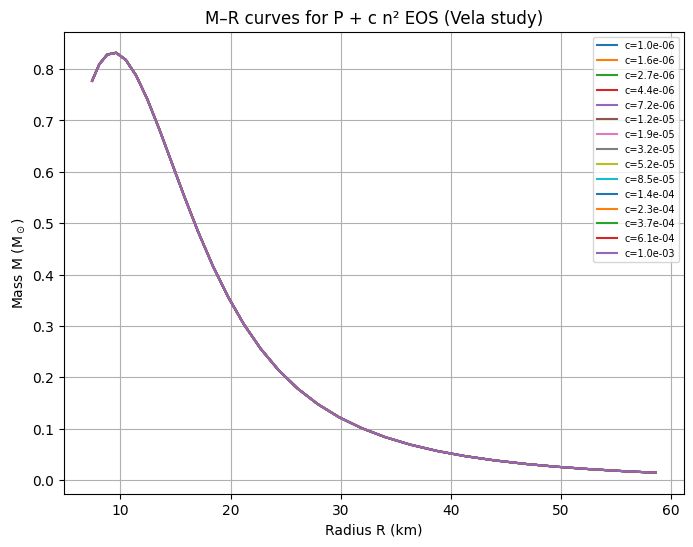

In [5]:
c_values = np.logspace(-6, -3, 15)
nc_values = np.logspace(-4, 1, 30)

MR_data = {}

plt.figure(figsize=(8,6))

for c in c_values:
    eos = CurvedEOS(c=c)
    M_list, R_list = [], []

    for nc in nc_values:
        try:
            M, R, *_ = integrate_star_curved(
                nc=nc,
                eos=eos,
                return_profile=False
            )
            if M > 0 and R > 0:
                M_list.append(M)
                R_list.append(R)
                print(f"M-R | c={c:.2e}, nc={nc:.3e} -> M={M:.3f}, R={R:.3f}")
        except:
            continue

    MR_data[c] = (np.array(M_list), np.array(R_list))

    if len(M_list) > 0:
        idx = np.argsort(R_list)
        plt.plot(np.array(R_list)[idx],
                 np.array(M_list)[idx],
                 label=f"c={c:.1e}")

plt.xlabel("Radius R (km)")
plt.ylabel("Mass M (M$_\odot$)")
plt.title("M–R curves for P + c n² EOS (Vela study)")
plt.legend(fontsize=7)
plt.grid(True)
plt.show()

R(c) | c=1.00e-06 -> R=14.9680
R(c) | c=1.64e-06 -> R=14.9680
R(c) | c=2.68e-06 -> R=14.9680
R(c) | c=4.39e-06 -> R=14.9680
R(c) | c=7.20e-06 -> R=14.9680
R(c) | c=1.18e-05 -> R=14.9680
R(c) | c=1.93e-05 -> R=14.9679
R(c) | c=3.16e-05 -> R=14.9679
R(c) | c=5.18e-05 -> R=14.9678
R(c) | c=8.48e-05 -> R=14.9676
R(c) | c=1.39e-04 -> R=14.9674
R(c) | c=2.28e-04 -> R=14.9670
R(c) | c=3.73e-04 -> R=14.9663
R(c) | c=6.11e-04 -> R=14.9653
R(c) | c=1.00e-03 -> R=14.9635


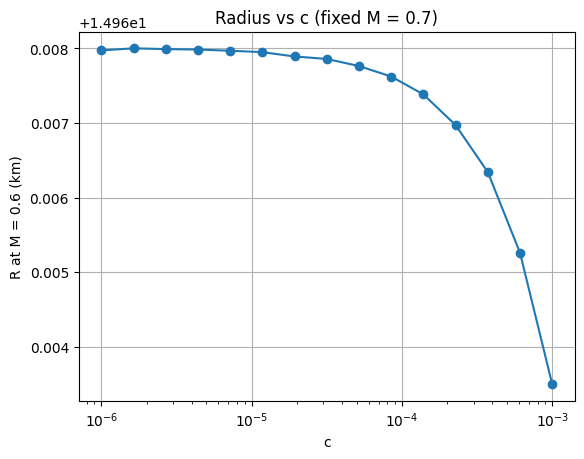

In [6]:
R_of_c = []
nc_of_c = []

for c, (M_arr, R_arr) in MR_data.items():
    if len(M_arr) < 5:
        continue

    order = np.argsort(M_arr)
    M_sorted = M_arr[order]
    R_sorted = R_arr[order]

    if M_sorted.min() <= M_target <= M_sorted.max():
        R_val = np.interp(M_target, M_sorted, R_sorted)
        R_of_c.append(R_val)
        nc_of_c.append(c)
        print(f"R(c) | c={c:.2e} -> R={R_val:.4f}")

plt.figure()
plt.semilogx(nc_of_c, R_of_c, "o-")
plt.xlabel("c")
plt.ylabel("R at M = 0.6 (km)")
plt.grid(True)
plt.title("Radius vs c (fixed M = 0.7)")
plt.show()

In [7]:
Omega_of_c = []
delta_Omega = []

J_ref = None
Omega_prev = Omega_ref

for c in c_values:
    eos = CurvedEOS(c=c)

    # --- find background star near M=0.7 ---
    best = None
    best_diff = np.inf

    for nc in nc_values:
        try:
            M, R, _, _, _, sol_bg = integrate_star_curved(
                nc=nc,
                eos=eos,
                return_profile=True
            )
            diff = abs(M - M_target)
            if diff < best_diff:
                best_diff = diff
                best = (nc, M, R, sol_bg)
        except:
            continue

    if best is None:
        continue

    nc_star, M_star, R_star, sol_bg = best

    # --- reference J (only once) ---
    if J_ref is None:
        _, _, _, J_ref, _ = integrate_frame_dragging(
            sol_bg=sol_bg,
            R=R_star,
            Omega=Omega_ref,
            eos=eos
        )
        print(f"Reference J = {J_ref:.6e}")

    # --- root-find Omega for fixed J ---
    def J_mismatch(Omega):
        _, _, _, J, _ = integrate_frame_dragging(
            sol_bg=sol_bg,
            R=R_star,
            Omega=Omega,
            eos=eos
        )
        return J - J_ref

    sol = root_scalar(
        J_mismatch,
        bracket=(0.95*Omega_prev, 1.05*Omega_prev),
        method="brentq"
    )

    Omega_star = sol.root
    Omega_of_c.append(Omega_star)
    delta_Omega.append(Omega_star - Omega_ref)

    Omega_prev = Omega_star

    print(
        f"Ω(c) | c={c:.2e}, "
        f"Omega={Omega_star:.8f}, "
        f"ΔΩ={Omega_star - Omega_ref:.3e}"
    )

Reference J = 2.023066e+03
Ω(c) | c=1.00e-06, Omega=70.33806040, ΔΩ=-3.411e-13
Ω(c) | c=1.64e-06, Omega=70.33804417, ΔΩ=-1.623e-05
Ω(c) | c=2.68e-06, Omega=70.33809534, ΔΩ=3.494e-05
Ω(c) | c=4.39e-06, Omega=70.33816684, ΔΩ=1.064e-04
Ω(c) | c=7.20e-06, Omega=70.33829325, ΔΩ=2.328e-04
Ω(c) | c=1.18e-05, Omega=70.33847679, ΔΩ=4.164e-04
Ω(c) | c=1.93e-05, Omega=70.33880882, ΔΩ=7.484e-04
Ω(c) | c=3.16e-05, Omega=70.33930403, ΔΩ=1.244e-03
Ω(c) | c=5.18e-05, Omega=70.34011044, ΔΩ=2.050e-03
Ω(c) | c=8.48e-05, Omega=70.34147611, ΔΩ=3.416e-03
Ω(c) | c=1.39e-04, Omega=70.34366744, ΔΩ=5.607e-03
Ω(c) | c=2.28e-04, Omega=70.34730569, ΔΩ=9.245e-03
Ω(c) | c=3.73e-04, Omega=70.35323508, ΔΩ=1.517e-02
Ω(c) | c=6.11e-04, Omega=70.36293315, ΔΩ=2.487e-02
Ω(c) | c=1.00e-03, Omega=70.37883416, ΔΩ=4.077e-02


In [8]:
delta_min = 1e-4
delta_max = 3e-4
delta_Omega = np.array(delta_Omega)
Omega_of_c = np.array(Omega_of_c)
c_arr = np.array(c_values[:len(delta_Omega)])
mask = (delta_Omega >= delta_min) & (delta_Omega <= delta_max)

c_allowed = c_arr[mask]
delta_allowed = delta_Omega[mask]
Omega_allowed = Omega_of_c[mask]

if len(c_allowed) == 0:
    print("No c values found in the desired ΔΩ range.")
else:
    print("\n=== ΔΩ WINDOW MATCH ===")
    print(f"ΔΩ range = [{delta_min:.2e}, {delta_max:.2e}]")
    print(f"c range  = [{c_allowed.min():.3e}, {c_allowed.max():.3e}]")

    for c, dO in zip(c_allowed, delta_allowed):
        print(f"  c = {c}  →  ΔΩ = {dO}")


=== ΔΩ WINDOW MATCH ===
ΔΩ range = [1.00e-04, 3.00e-04]
c range  = [4.394e-06, 7.197e-06]
  c = 4.393970560760786e-06  →  ΔΩ = 0.00010643740519356015
  c = 7.196856730011514e-06  →  ΔΩ = 0.00023284825586245006


In [9]:
R_range = []
nc_range = []

for c in c_allowed:
    eos = CurvedEOS(c=c)

    best_diff = np.inf
    best = None

    for nc in nc_values:
        try:
            M, R, *_ = integrate_star_curved(nc, eos, return_profile=False)
            diff = abs(M - M_target)
            if diff < best_diff:
                best_diff = diff
                best = (nc, R)
        except:
            continue

    if best is not None:
        nc_range.append(best[0])
        R_range.append(best[1])

print("\n=== INFERRED STAR PROPERTY RANGES ===")
print(f"R range  = [{min(R_range)}, {max(R_range)}] km")
print(f"nc range = [{min(nc_range)}, {max(nc_range)}] fm⁻³")


=== INFERRED STAR PROPERTY RANGES ===
R range  = [14.624499170490907, 14.624515616179865] km
nc range = [0.4175318936560405, 0.4175318936560405] fm⁻³


In [14]:
# --- Vela pulsar inputs ---
F0 = 11.19465                       # Hz
Omega_ref = 2.0 * np.pi * F0        # rad/s ≈ 70.338
delta_Omega_target = 1.438e-4       # target change in Omega

M_target = 0.5                      # Msun

<>:35: SyntaxWarning: invalid escape sequence '\o'
<>:35: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-525706467.py:35: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Mass M (M$_\odot$)")


M-R | c=1.00e-06, nc=1.000e-04 -> M=0.014, R=58.633
M-R | c=1.00e-06, nc=1.487e-04 -> M=0.017, R=55.637
M-R | c=1.00e-06, nc=2.212e-04 -> M=0.021, R=52.630
M-R | c=1.00e-06, nc=3.290e-04 -> M=0.026, R=49.664
M-R | c=1.00e-06, nc=4.894e-04 -> M=0.031, R=46.774
M-R | c=1.00e-06, nc=7.279e-04 -> M=0.038, R=43.986
M-R | c=1.00e-06, nc=1.083e-03 -> M=0.046, R=41.313
M-R | c=1.00e-06, nc=1.610e-03 -> M=0.057, R=38.766
M-R | c=1.00e-06, nc=2.395e-03 -> M=0.069, R=36.347
M-R | c=1.00e-06, nc=3.562e-03 -> M=0.083, R=34.055
M-R | c=1.00e-06, nc=5.298e-03 -> M=0.101, R=31.888
M-R | c=1.00e-06, nc=7.880e-03 -> M=0.122, R=29.842
M-R | c=1.00e-06, nc=1.172e-02 -> M=0.148, R=27.911
M-R | c=1.00e-06, nc=1.743e-02 -> M=0.178, R=26.089
M-R | c=1.00e-06, nc=2.593e-02 -> M=0.214, R=24.369
M-R | c=1.00e-06, nc=3.857e-02 -> M=0.255, R=22.744
M-R | c=1.00e-06, nc=5.736e-02 -> M=0.303, R=21.206
M-R | c=1.00e-06, nc=8.532e-02 -> M=0.358, R=19.750
M-R | c=1.00e-06, nc=1.269e-01 -> M=0.418, R=18.369
M-R | c=1.00

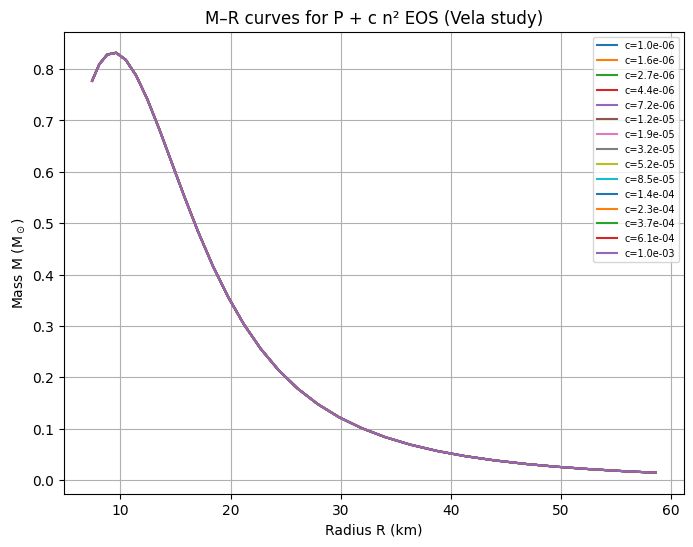

In [15]:
c_values = np.logspace(-6, -3, 15)
nc_values = np.logspace(-4, 1, 30)

MR_data = {}

plt.figure(figsize=(8,6))

for c in c_values:
    eos = CurvedEOS(c=c)
    M_list, R_list = [], []

    for nc in nc_values:
        try:
            M, R, *_ = integrate_star_curved(
                nc=nc,
                eos=eos,
                return_profile=False
            )
            if M > 0 and R > 0:
                M_list.append(M)
                R_list.append(R)
                print(f"M-R | c={c:.2e}, nc={nc:.3e} -> M={M:.3f}, R={R:.3f}")
        except:
            continue

    MR_data[c] = (np.array(M_list), np.array(R_list))

    if len(M_list) > 0:
        idx = np.argsort(R_list)
        plt.plot(np.array(R_list)[idx],
                 np.array(M_list)[idx],
                 label=f"c={c:.1e}")

plt.xlabel("Radius R (km)")
plt.ylabel("Mass M (M$_\odot$)")
plt.title("M–R curves for P + c n² EOS (Vela study)")
plt.legend(fontsize=7)
plt.grid(True)
plt.show()

R(c) | c=1.00e-06 -> R=16.7505
R(c) | c=1.64e-06 -> R=16.7505
R(c) | c=2.68e-06 -> R=16.7505
R(c) | c=4.39e-06 -> R=16.7505
R(c) | c=7.20e-06 -> R=16.7505
R(c) | c=1.18e-05 -> R=16.7505
R(c) | c=1.93e-05 -> R=16.7504
R(c) | c=3.16e-05 -> R=16.7504
R(c) | c=5.18e-05 -> R=16.7503
R(c) | c=8.48e-05 -> R=16.7502
R(c) | c=1.39e-04 -> R=16.7500
R(c) | c=2.28e-04 -> R=16.7497
R(c) | c=3.73e-04 -> R=16.7492
R(c) | c=6.11e-04 -> R=16.7483
R(c) | c=1.00e-03 -> R=16.7470


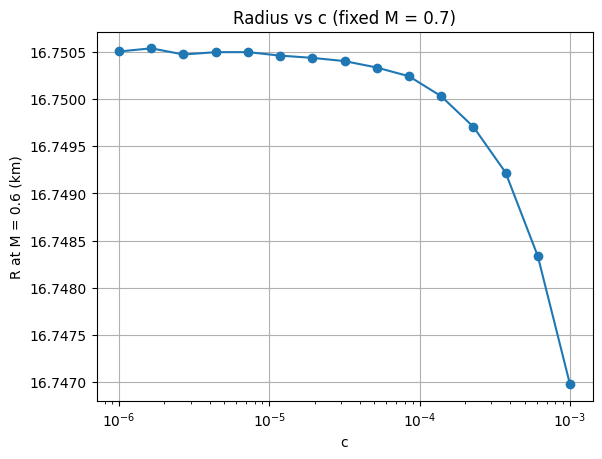

In [16]:
R_of_c = []
nc_of_c = []

for c, (M_arr, R_arr) in MR_data.items():
    if len(M_arr) < 5:
        continue

    order = np.argsort(M_arr)
    M_sorted = M_arr[order]
    R_sorted = R_arr[order]

    if M_sorted.min() <= M_target <= M_sorted.max():
        R_val = np.interp(M_target, M_sorted, R_sorted)
        R_of_c.append(R_val)
        nc_of_c.append(c)
        print(f"R(c) | c={c:.2e} -> R={R_val:.4f}")

plt.figure()
plt.semilogx(nc_of_c, R_of_c, "o-")
plt.xlabel("c")
plt.ylabel("R at M = 0.6 (km)")
plt.grid(True)
plt.title("Radius vs c (fixed M = 0.7)")
plt.show()

In [17]:
Omega_of_c = []
delta_Omega = []

J_ref = None
Omega_prev = Omega_ref

for c in c_values:
    eos = CurvedEOS(c=c)

    # --- find background star near M=0.7 ---
    best = None
    best_diff = np.inf

    for nc in nc_values:
        try:
            M, R, _, _, _, sol_bg = integrate_star_curved(
                nc=nc,
                eos=eos,
                return_profile=True
            )
            diff = abs(M - M_target)
            if diff < best_diff:
                best_diff = diff
                best = (nc, M, R, sol_bg)
        except:
            continue

    if best is None:
        continue

    nc_star, M_star, R_star, sol_bg = best

    # --- reference J (only once) ---
    if J_ref is None:
        _, _, _, J_ref, _ = integrate_frame_dragging(
            sol_bg=sol_bg,
            R=R_star,
            Omega=Omega_ref,
            eos=eos
        )
        print(f"Reference J = {J_ref:.6e}")

    # --- root-find Omega for fixed J ---
    def J_mismatch(Omega):
        _, _, _, J, _ = integrate_frame_dragging(
            sol_bg=sol_bg,
            R=R_star,
            Omega=Omega,
            eos=eos
        )
        return J - J_ref

    sol = root_scalar(
        J_mismatch,
        bracket=(0.95*Omega_prev, 1.05*Omega_prev),
        method="brentq"
    )

    Omega_star = sol.root
    Omega_of_c.append(Omega_star)
    delta_Omega.append(Omega_star - Omega_ref)

    Omega_prev = Omega_star

    print(
        f"Ω(c) | c={c:.2e}, "
        f"Omega={Omega_star:.8f}, "
        f"ΔΩ={Omega_star - Omega_ref:.3e}"
    )

Reference J = 2.106794e+03
Ω(c) | c=1.00e-06, Omega=70.33806040, ΔΩ=-4.547e-13
Ω(c) | c=1.64e-06, Omega=70.33808847, ΔΩ=2.807e-05
Ω(c) | c=2.68e-06, Omega=70.33810710, ΔΩ=4.670e-05
Ω(c) | c=4.39e-06, Omega=70.33814336, ΔΩ=8.296e-05
Ω(c) | c=7.20e-06, Omega=70.33825300, ΔΩ=1.926e-04
Ω(c) | c=1.18e-05, Omega=70.33842420, ΔΩ=3.638e-04
Ω(c) | c=1.93e-05, Omega=70.33860296, ΔΩ=5.426e-04
Ω(c) | c=3.16e-05, Omega=70.33902382, ΔΩ=9.634e-04
Ω(c) | c=5.18e-05, Omega=70.33962461, ΔΩ=1.564e-03
Ω(c) | c=8.48e-05, Omega=70.34072666, ΔΩ=2.666e-03
Ω(c) | c=1.39e-04, Omega=70.34240460, ΔΩ=4.344e-03
Ω(c) | c=2.28e-04, Omega=70.34518874, ΔΩ=7.128e-03
Ω(c) | c=3.73e-04, Omega=70.34981250, ΔΩ=1.175e-02
Ω(c) | c=6.11e-04, Omega=70.35735326, ΔΩ=1.929e-02
Ω(c) | c=1.00e-03, Omega=70.36965431, ΔΩ=3.159e-02


In [18]:
delta_min = 1e-4
delta_max = 3e-4
delta_Omega = np.array(delta_Omega)
Omega_of_c = np.array(Omega_of_c)
c_arr = np.array(c_values[:len(delta_Omega)])
mask = (delta_Omega >= delta_min) & (delta_Omega <= delta_max)

c_allowed = c_arr[mask]
delta_allowed = delta_Omega[mask]
Omega_allowed = Omega_of_c[mask]

if len(c_allowed) == 0:
    print("No c values found in the desired ΔΩ range.")
else:
    print("\n=== ΔΩ WINDOW MATCH ===")
    print(f"ΔΩ range = [{delta_min:.2e}, {delta_max:.2e}]")
    print(f"c range  = [{c_allowed.min():.3e}, {c_allowed.max():.3e}]")

    for c, dO in zip(c_allowed, delta_allowed):
        print(f"  c = {c}  →  ΔΩ = {dO}")


=== ΔΩ WINDOW MATCH ===
ΔΩ range = [1.00e-04, 3.00e-04]
c range  = [7.197e-06, 7.197e-06]
  c = 7.196856730011514e-06  →  ΔΩ = 0.00019260166443757498


In [19]:
R_range = []
nc_range = []

for c in c_allowed:
    eos = CurvedEOS(c=c)

    best_diff = np.inf
    best = None

    for nc in nc_values:
        try:
            M, R, *_ = integrate_star_curved(nc, eos, return_profile=False)
            diff = abs(M - M_target)
            if diff < best_diff:
                best_diff = diff
                best = (nc, R)
        except:
            continue

    if best is not None:
        nc_range.append(best[0])
        R_range.append(best[1])

print("\n=== INFERRED STAR PROPERTY RANGES ===")
print(f"R range  = [{min(R_range)}, {max(R_range)}] km")
print(f"nc range = [{min(nc_range)}, {max(nc_range)}] fm⁻³")


=== INFERRED STAR PROPERTY RANGES ===
R range  = [17.0577320573781, 17.0577320573781] km
nc range = [0.18873918221350977, 0.18873918221350977] fm⁻³
